## Continuous Sapientino.

Level of abstraction "two", with restraining bolts.

The goal is to visit N colors in a certain order.

In [1]:
%matplotlib inline

import tempfile
from pathlib import Path
from multinav.envs.grid_sapientino import generate_grid
from multinav.wrappers.sapientino import GridRobotFeatures
from multinav.wrappers.temprl import MyTemporalGoalWrapper
from multinav.wrappers.utils import SingleAgentWrapper
from gym_sapientino.core.configurations import SapientinoConfiguration, SapientinoAgentConfiguration

from gym_sapientino import SapientinoDictSpace
from multinav.helpers.gym import rollout
from multinav.helpers.notebooks import plot_env, display_img_array
from multinav.restraining_bolts.rb_grid_sapientino import GridSapientinoRB

pygame 2.0.0 (SDL 2.0.12, python 3.7.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


Before temporal goal wrapper:
Observation space: Dict(beep:Discrete(2), color:Discrete(10), x:Discrete(9), y:Discrete(5))
Action space: Discrete(6)
After temporal goal wrapper:
Observation space: MultiDiscrete([9 5 6])
Action space: Discrete(6)


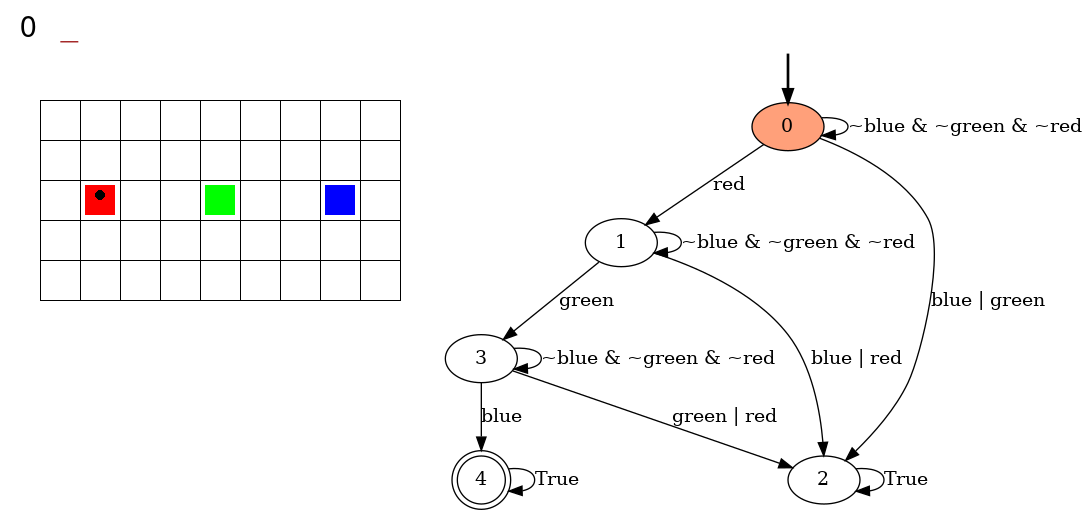

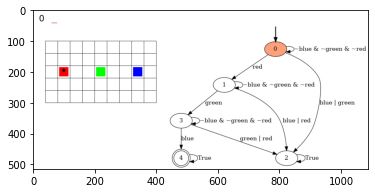

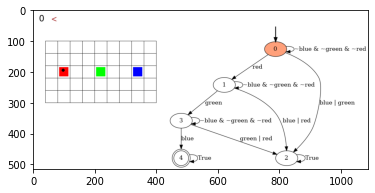

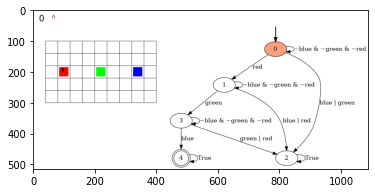

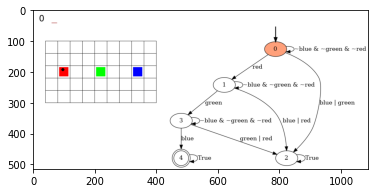

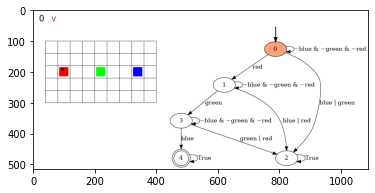

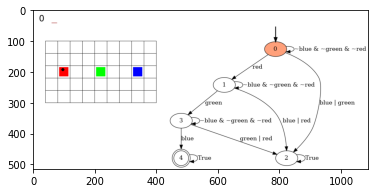

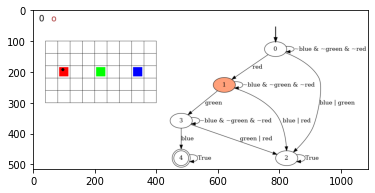

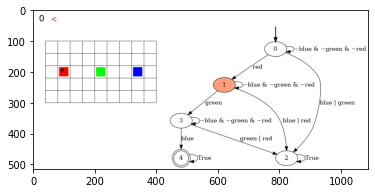

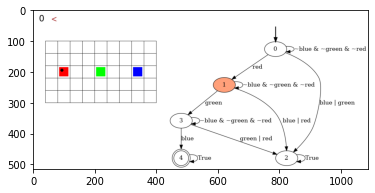

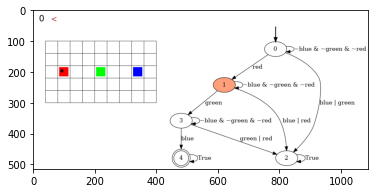

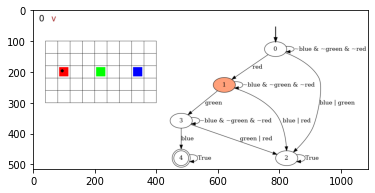

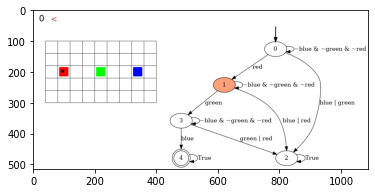

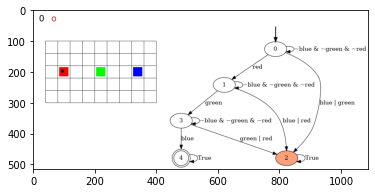

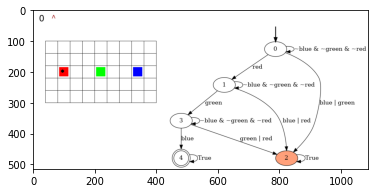

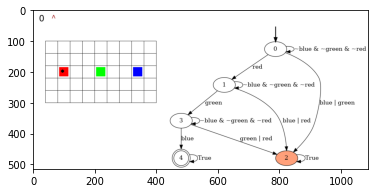

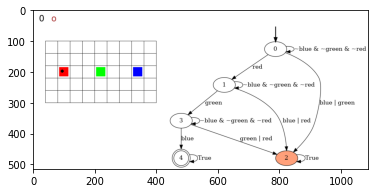

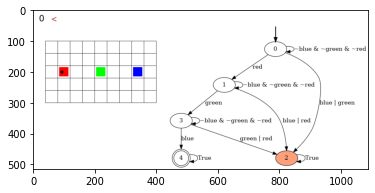

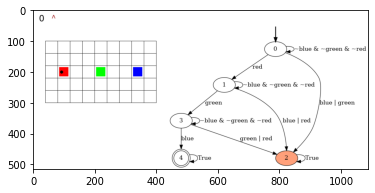

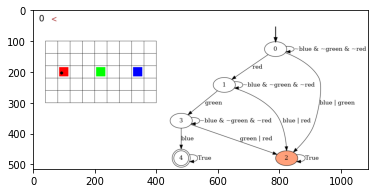

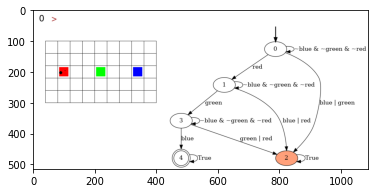

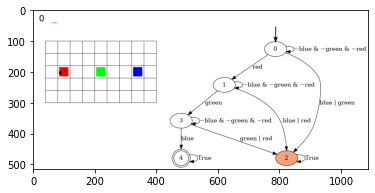

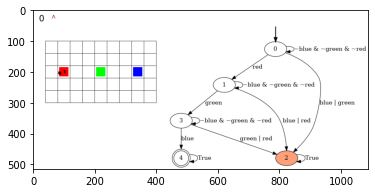

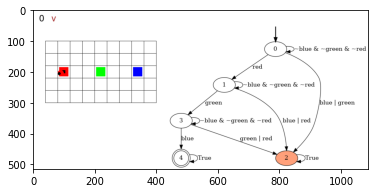

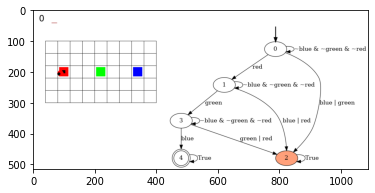

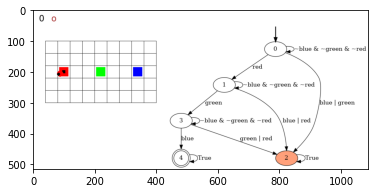

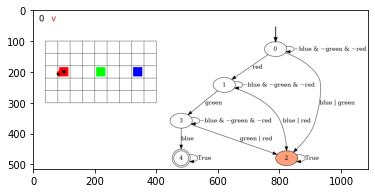

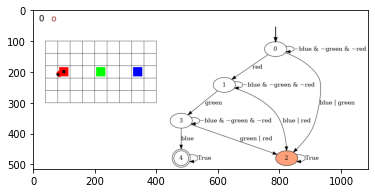

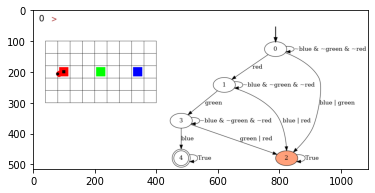

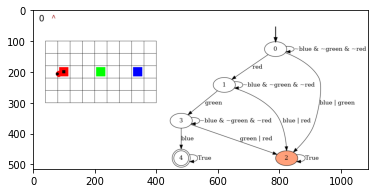

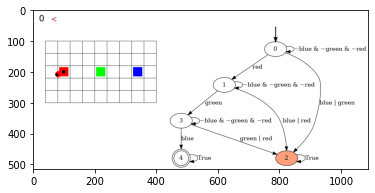

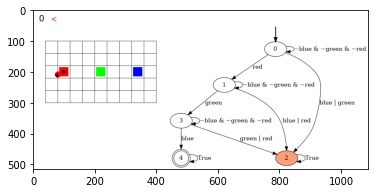

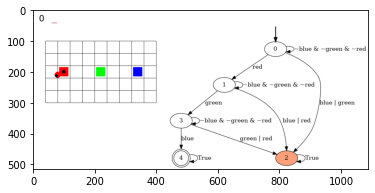

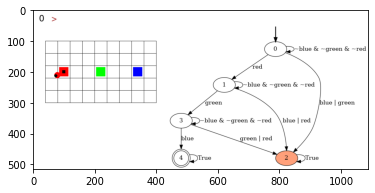

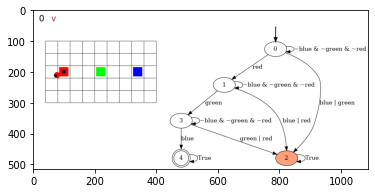

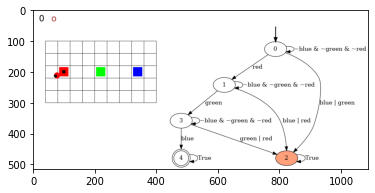

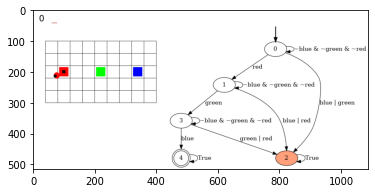

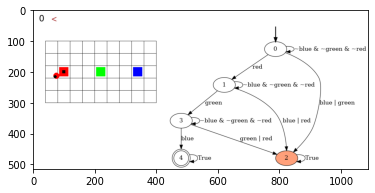

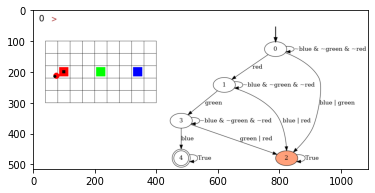

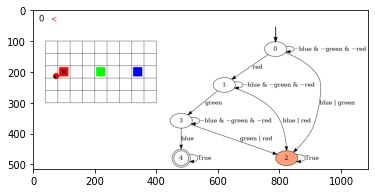

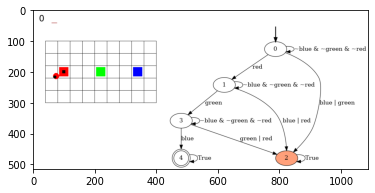

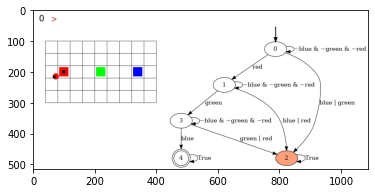

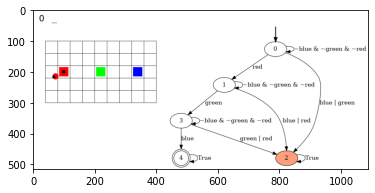

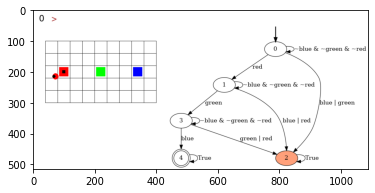

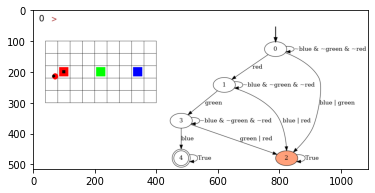

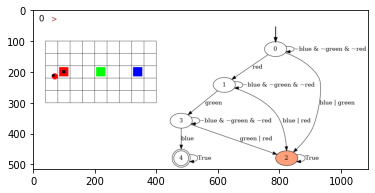

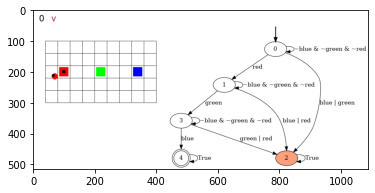

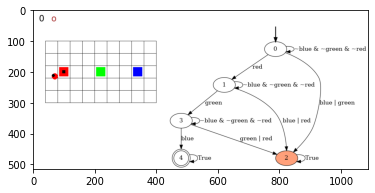

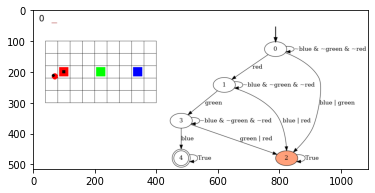

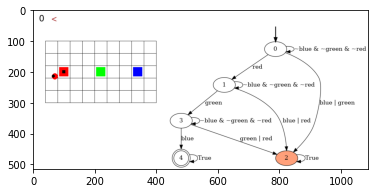

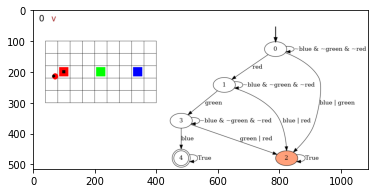

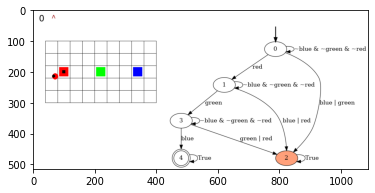

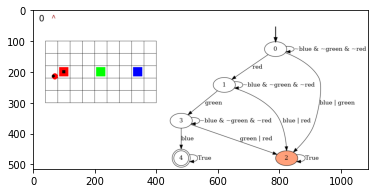

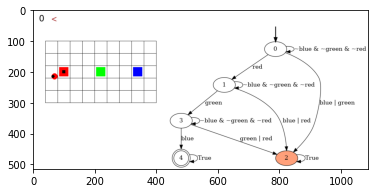

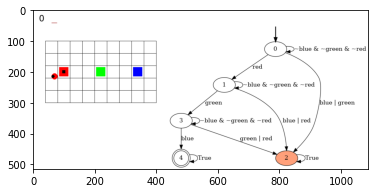

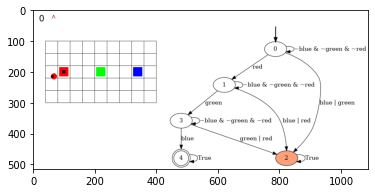

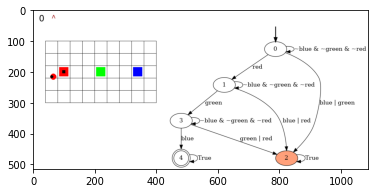

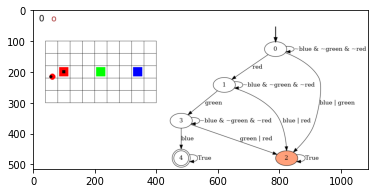

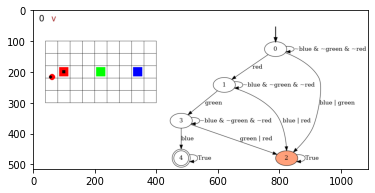

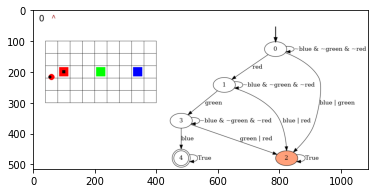

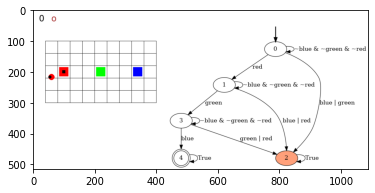

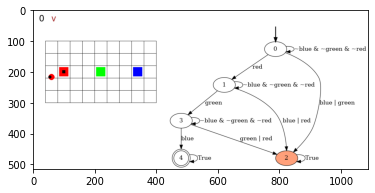

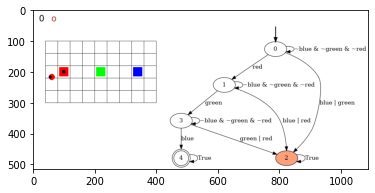

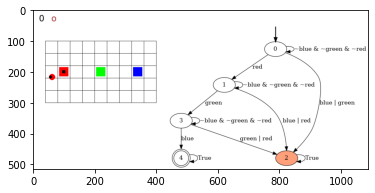

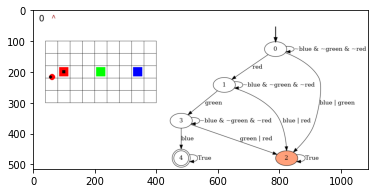

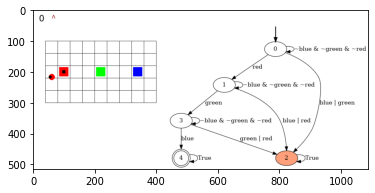

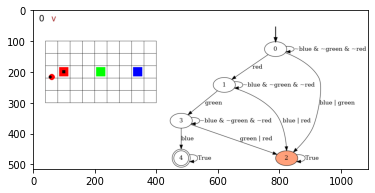

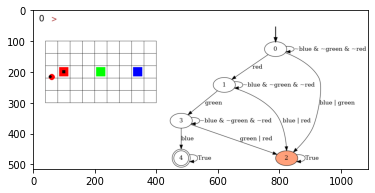

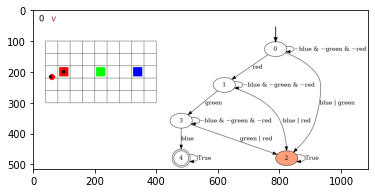

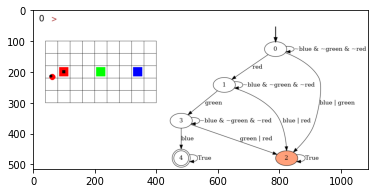

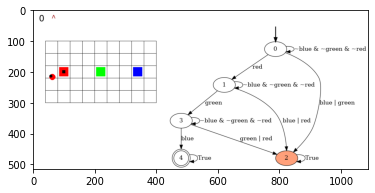

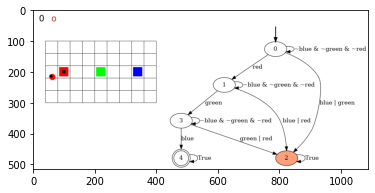

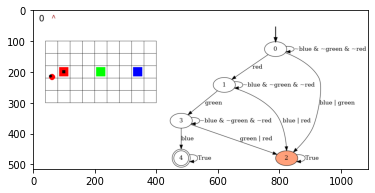

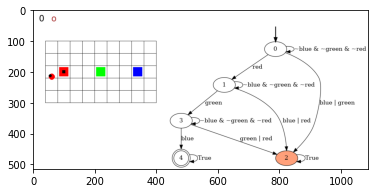

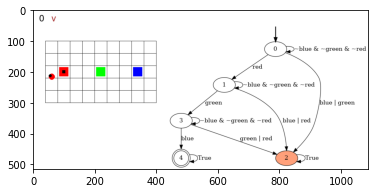

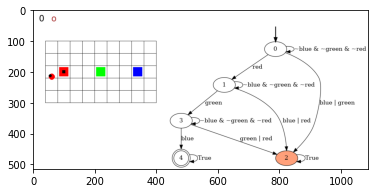

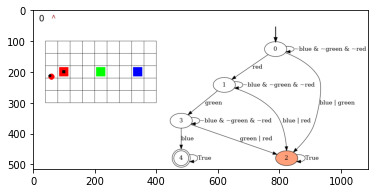

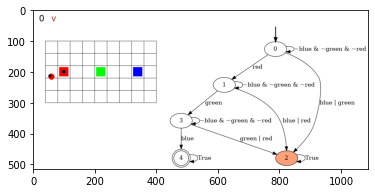

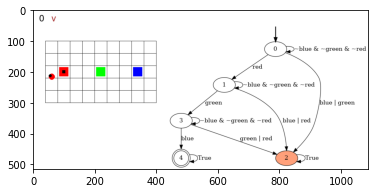

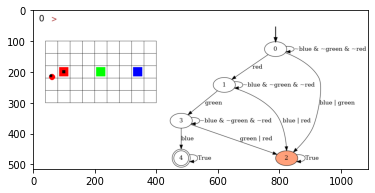

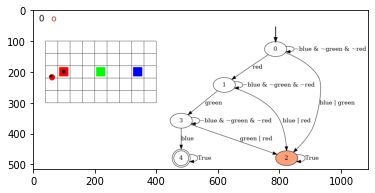

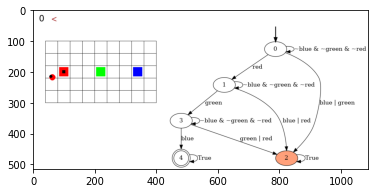

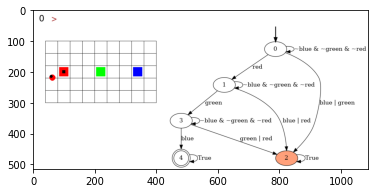

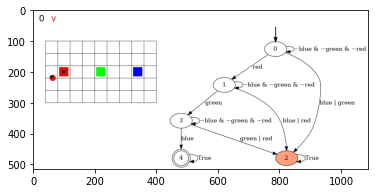

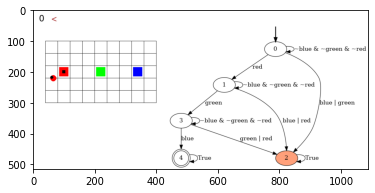

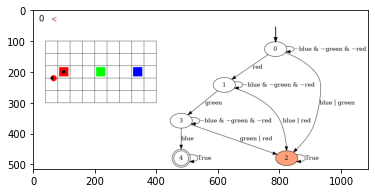

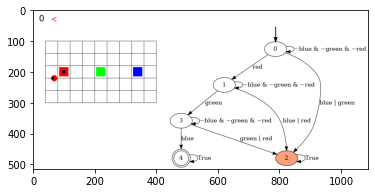

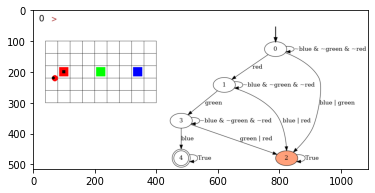

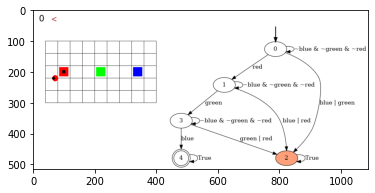

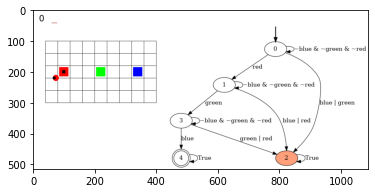

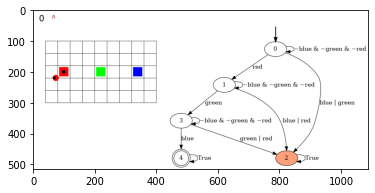

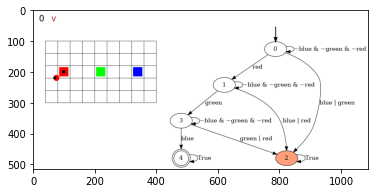

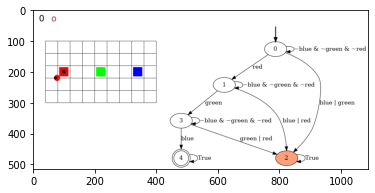

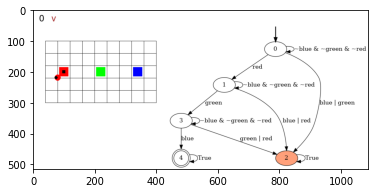

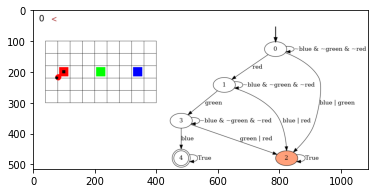

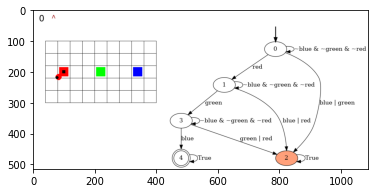

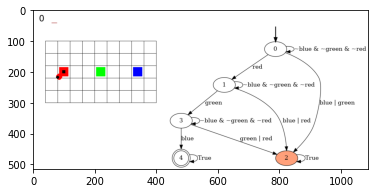

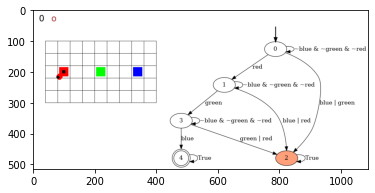

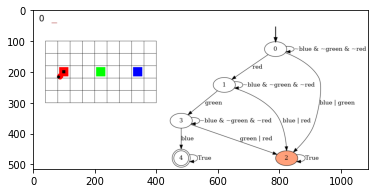

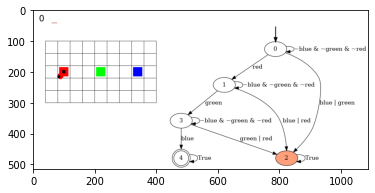

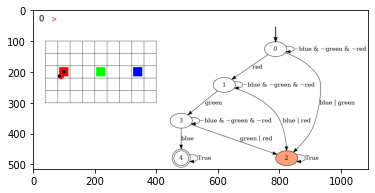

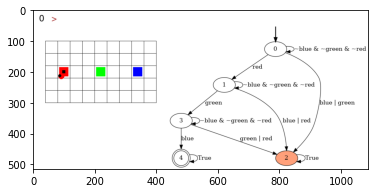

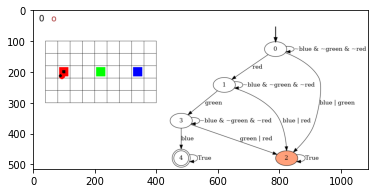

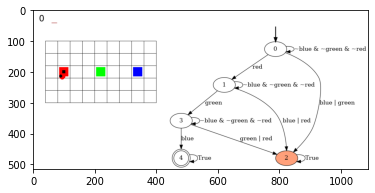

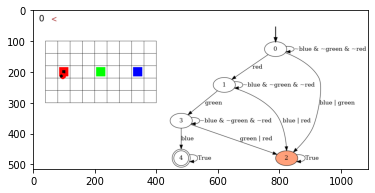

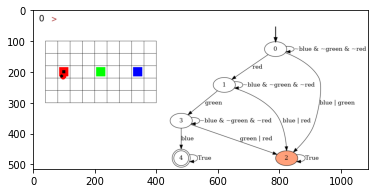

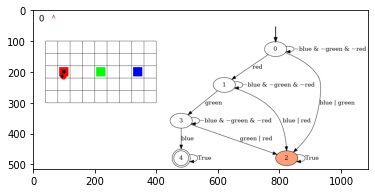

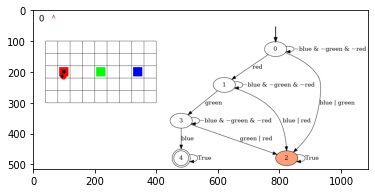

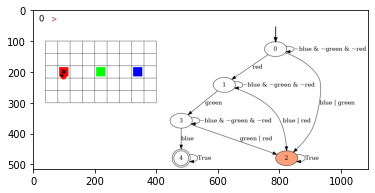

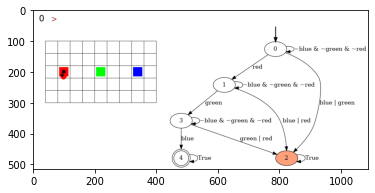

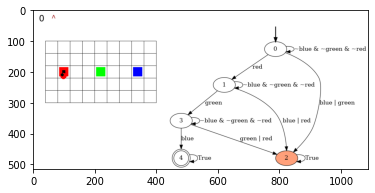

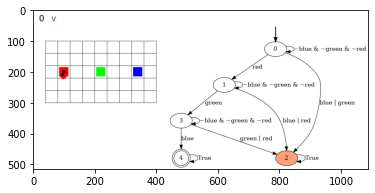

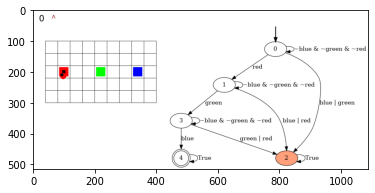

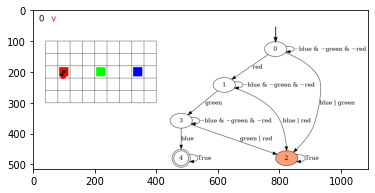

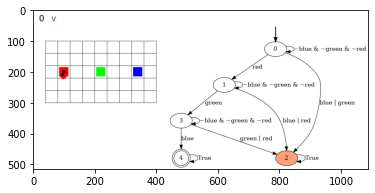

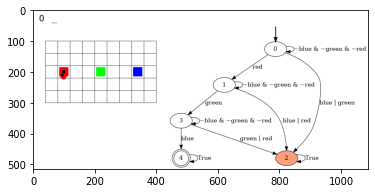

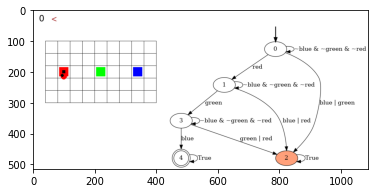

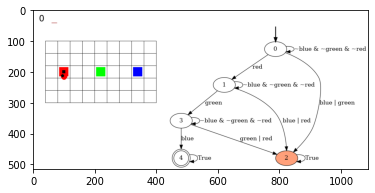

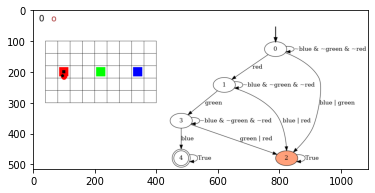

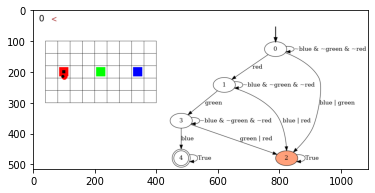

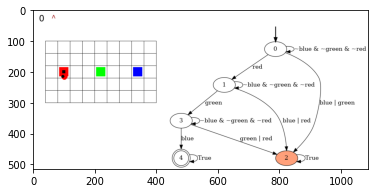

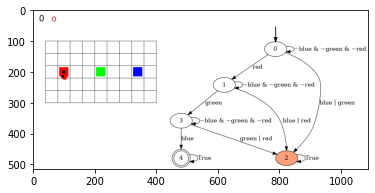

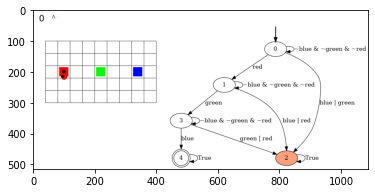

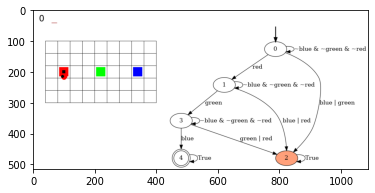

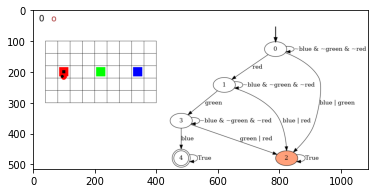

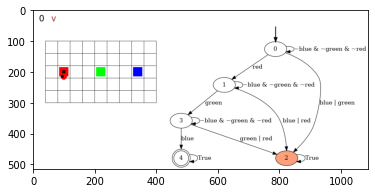

KeyboardInterrupt: 

In [2]:
nb_colors = 3
temp_file = Path(tempfile.mktemp(suffix=".txt"))
generate_grid(nb_colors, temp_file)
agent_configuration = SapientinoAgentConfiguration(continuous=True)
configuration = SapientinoConfiguration(
    [agent_configuration],
    path_to_map=temp_file,
    reward_per_step=-0.01,
    reward_outside_grid=0.0,
    reward_duplicate_beep=0.0,
)
env = SingleAgentWrapper(SapientinoDictSpace(configuration))
tg = GridSapientinoRB(nb_colors).make_sapientino_goal()
print("Before temporal goal wrapper:")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
env = GridRobotFeatures(MyTemporalGoalWrapper(env, [tg]))
print("After temporal goal wrapper:")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

display_img_array(env.render(mode="rgb_array"))


rollout(env, callback=plot_env)


In [ ]:
# env.cleanup()
# Q = dqn(env, nb_steps=5000, tensorboard_log="./dqn_rotmab_tensorboard/", tb_log_name="DQN_markov")
# env.cleanup()
# evaluate(env, Q)